<a href="https://colab.research.google.com/github/AImSecure/Laboratory1/blob/main/lab/notebooks/Lab1_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 1 — Feed Forward Neural Networks

This notebook follows the lab brief in `resources/Lab1_FFNN.txt` and is organized into tasks:
- Task 1: Data preprocessing (cleaning, splitting, outliers, normalization)
- Task 2: Shallow NN (1 layer), train sizes {32, 64, 128}, metrics and analysis; then ReLU change
- Task 3: Impact of specific features (Destination Port), bias test and port removal
- Task 4: Loss function impact (weighted CrossEntropy)
- Task 5: Deep NN, batch size, optimizer comparisons
- Task 6: Overfitting and regularization (dropout, batchnorm, weight decay)

## Setup

In [102]:
# --- Check Python & pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12


In [103]:

# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [104]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [105]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [106]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [107]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory1'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# --- Ensure directories exist ---
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/


In [109]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    print(f"Saved plot: {save_path}")

## Task 1 — Data preprocessing
What we will do:
- Load CSV from `lab/data/dataset_lab_1.csv`
- Inspect basic info, class distribution, and feature ranges
- Remove NaN and duplicate rows; report counts before/after
- Split into train/val/test with stratify (60/20/20, fixed SEED)
- Inspect outliers on train/val (e.g., boxplots, z-scores) and choose normalization
- Fit scaler on train only; transform val/test; persist scaler if needed

In [121]:
# --- Load dataset and perform initial inspection ---

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

# Load Dataset
file_path = data_path + 'dataset_lab_1.csv'
df = pd.read_csv(file_path)

print("Shape (raw):", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

# Basic info
print("\nLabel distribution (raw):")
print(df['Label'].value_counts(dropna=False))

Shape (raw): (31507, 17)
Columns: ['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port', 'Label']
   Flow Duration  Flow IAT Mean  Fwd PSH Flags  Bwd Packet Length Mean  \
0         303376        30337.6              0                   749.4   
1            117          117.0              0                     0.0   
2            142          142.0              0                     0.0   

   Bwd Packet Length Max  Flow Bytes/s  Down/Up Ratio  SYN Flag Count  \
0                   1448     12743.263              0               0   
1                      0         0.000              1               0   
2                      0     84507.040              0               0   

   Fwd Packet Length Mean  Fwd IAT Std  Pac

In [122]:
def plot_class_distribution(
    df,
    label_col='Label',
    save_path='./plots/',
    fig_size=(8, 5),
    color='Set2'
):
    """
    Plot the number of samples for each class.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_col (str): The name of the label column. Defaults to 'Label'.
        save_path (str): The directory to save the plot. Defaults to './plots/'.
        fig_size (tuple): Size of the figure. Defaults to (8, 5).
        color (str): Seaborn color.
    """
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # Create a countplot showing the distribution of classes
    sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, ax=ax, color='skyblue')

    # Set the title and labels for the plot
    ax.set_title("Class Distribution")
    ax.set_xlabel("Traffic Type")
    ax.set_ylabel("Count")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    # Save the plot to the specified path
    save_plot(fig, "class_distribution", save_path)

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/class_distribution.png


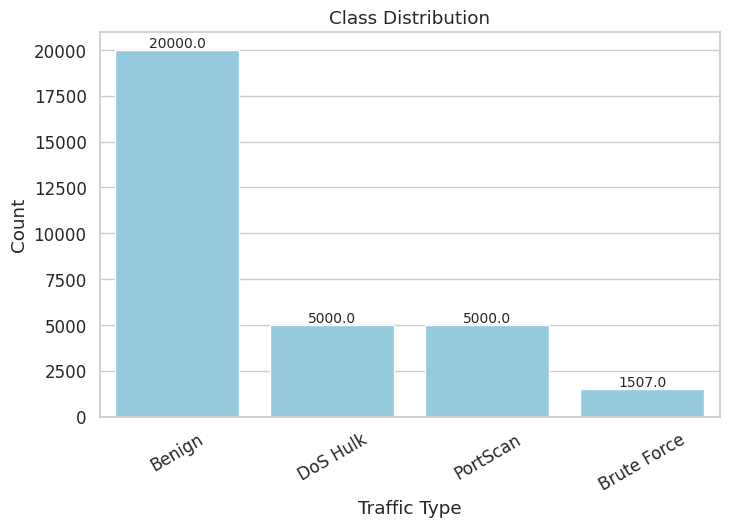

In [123]:
# --- Visualize raw data characteristics and distributions ---

# Plot class distribution to understand data balance
plot_class_distribution(df, save_path=save_dir)

# TODO: check for other useful plots

### Removing NaN and duplicates

In [124]:
# --- Remove NaN and duplicates ---

raw_n = len(df)
df = df.dropna()
df = df.drop_duplicates()
clean_n = len(df)

print(f"Removed {raw_n-clean_n} rows (NaN+dupes). New shape: {df.shape}")

Removed 2114 rows (NaN+dupes). New shape: (29393, 17)


In [125]:
# --- Handle infinite values ---

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for and report the number of infinite values (now NaNs)
inf_counts = df.isnull().sum()
print("\nNumber of infinite values (replaced with NaN) per column:")
print(inf_counts[inf_counts > 0])

# Drop rows with NaN values (including those that were originally infinite)
initial_rows = len(df)
df.dropna(inplace=True)
rows_after_inf_nan_drop = len(df)

print(f"\nRemoved {initial_rows - rows_after_inf_nan_drop} rows containing infinite or NaN values. New shape: {df.shape}")


Number of infinite values (replaced with NaN) per column:
Flow Bytes/s      7
Flow Packets/s    7
dtype: int64

Removed 7 rows containing infinite or NaN values. New shape: (29386, 17)


In [126]:
print("\nLabel distribution (after NaN and duplicates removal):")
print(df['Label'].value_counts())


Label distribution (after NaN and duplicates removal):
Label
Benign         19242
PortScan        4849
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64


In [127]:
# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

df.head()

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,30337.600000,0,749.4,1448,12743.263,0,0,19.833334,98776.15,322.16666,119,6,36.258636,6,443,0
1,117,117.000000,0,0.0,0,0.000,1,0,0.000000,0.00,0.00000,0,1,17094.018000,1,52631,0
2,142,142.000000,0,0.0,0,84507.040,0,0,6.000000,0.00,6.00000,6,2,14084.507000,2,80,0
3,191,63.666668,0,52.0,52,921465.940,1,0,36.000000,0.00,42.40000,36,2,20942.408000,2,53,0
4,4,4.000000,0,0.0,0,3000000.000,0,0,6.000000,0.00,6.00000,6,2,500000.000000,2,49467,0


### Split data

In [128]:
# --- Split data ---

# Split features/target
label_col = 'Label'
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols]
y = df[label_col]

# We use a stratified approach due to the class imbalance

# Train/val/test split 60/20/20 with stratify
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)
print("Train label counts:\n", y_train.value_counts())
print("Val label counts:\n", y_val.value_counts())
print("Test label counts:\n", y_test.value_counts())

Splits: (17631, 16) (5877, 16) (5878, 16)
Train label counts:
 Label
0    11545
3     2909
2     2321
1      856
Name: count, dtype: int64
Val label counts:
 Label
0    3848
3     970
2     773
1     286
Name: count, dtype: int64
Test label counts:
 Label
0    3849
3     970
2     774
1     285
Name: count, dtype: int64


### Normalize data and handle outliers

In [129]:
# ------------------------------------------------------------
# STEP 1 — Identify continuous vs binary/categorical features
# ------------------------------------------------------------
cont_cols = [
    'Flow Duration', 'Flow IAT Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Max',
    'Flow Bytes/s', 'Down/Up Ratio', 'Fwd Packet Length Mean', 'Fwd IAT Std',
    'Packet Length Mean', 'Fwd Packet Length Max', 'Flow Packets/s'
]

skip_cols = [
    'Fwd PSH Flags', 'SYN Flag Count', 'Subflow Fwd Packets', 'Total Fwd Packets', 'Destination Port'
]

In [130]:
# ------------------------------------------------------------
# STEP 2 — Outlier detection (Z-score and IQR)
# ------------------------------------------------------------
# Z-score method
zs = ((X_train[cont_cols] - X_train[cont_cols].mean()) / X_train[cont_cols].std(ddof=0)).abs()
outlier_counts_z = (zs > 3).sum().sort_values(ascending=False)
print("\n[Z-SCORE OUTLIERS] Top 10 continuous features:")
print(outlier_counts_z.head(10))

# IQR method
Q1 = X_train[cont_cols].quantile(0.25)
Q3 = X_train[cont_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train[cont_cols] < (Q1 - 1.5 * IQR)) | (X_train[cont_cols] > (Q3 + 1.5 * IQR))).sum()
outlier_counts_iqr = outliers_iqr.sort_values(ascending=False)
print("\n[IQR OUTLIERS] Top 10 continuous features:")
print(outlier_counts_iqr.head(10))


[Z-SCORE OUTLIERS] Top 10 continuous features:
Fwd IAT Std               567
Bwd Packet Length Max     523
Flow Packets/s            522
Bwd Packet Length Mean    340
Packet Length Mean        272
Fwd Packet Length Max     238
Flow IAT Mean             207
Fwd Packet Length Mean    157
Down/Up Ratio              48
Flow Bytes/s               37
dtype: int64

[IQR OUTLIERS] Top 10 continuous features:
Bwd Packet Length Max     3951
Flow Duration             3443
Bwd Packet Length Mean    3180
Packet Length Mean        2982
Flow IAT Mean             2913
Flow Bytes/s              2826
Fwd IAT Std               2662
Flow Packets/s            1417
Fwd Packet Length Mean     997
Fwd Packet Length Max      929
dtype: int64


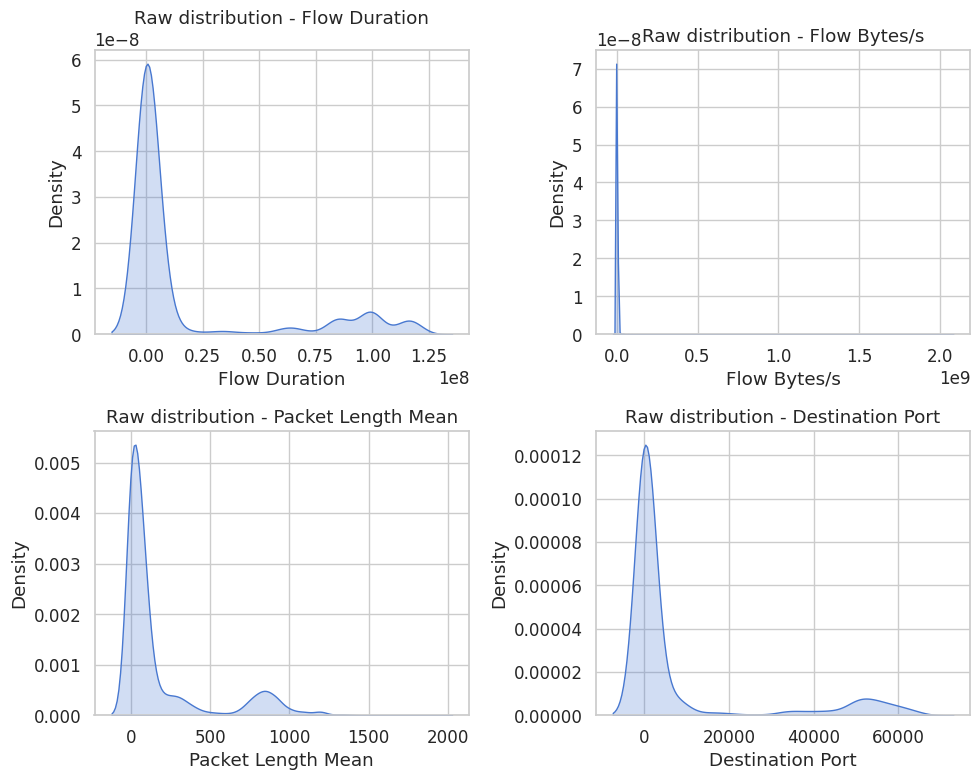

In [131]:
# ------------------------------------------------------------
# STEP 3 — Visualize raw distributions for selected features
# ------------------------------------------------------------
selected_features = ['Flow Duration', 'Flow Bytes/s', 'Packet Length Mean', 'Destination Port'] # TODO: change

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train[col], ax=axes[i//2, i%2], fill=True)
    axes[i//2, i%2].set_title(f"Raw distribution - {col}")
plt.tight_layout()
plt.show()


In [132]:
# ------------------------------------------------------------
# STEP 4 — Apply StandardScaler and RobustScaler (continuous features only)
# ------------------------------------------------------------
scaler_std = StandardScaler().fit(X_train[cont_cols])
scaler_rob = RobustScaler().fit(X_train[cont_cols])

# Transform continuous features
X_train_std_cont = pd.DataFrame(scaler_std.transform(X_train[cont_cols]), columns=cont_cols, index=X_train.index)
X_val_std_cont = pd.DataFrame(scaler_std.transform(X_val[cont_cols]), columns=cont_cols, index=X_val.index)
X_test_std_cont = pd.DataFrame(scaler_std.transform(X_test[cont_cols]), columns=cont_cols, index=X_test.index)

X_train_rob_cont = pd.DataFrame(scaler_rob.transform(X_train[cont_cols]), columns=cont_cols, index=X_train.index)
X_val_rob_cont = pd.DataFrame(scaler_rob.transform(X_val[cont_cols]), columns=cont_cols, index=X_val.index)
X_test_rob_cont = pd.DataFrame(scaler_rob.transform(X_test[cont_cols]), columns=cont_cols, index=X_test.index)

In [133]:
# ------------------------------------------------------------
# STEP 5 — Concatenate unscaled binary/categorical features
# ------------------------------------------------------------
X_train_std = pd.concat([X_train_std_cont, X_train[skip_cols]], axis=1)
X_val_std = pd.concat([X_val_std_cont, X_val[skip_cols]], axis=1)
X_test_std = pd.concat([X_test_std_cont, X_test[skip_cols]], axis=1)

X_train_rob = pd.concat([X_train_rob_cont, X_train[skip_cols]], axis=1)
X_val_rob = pd.concat([X_val_rob_cont, X_val[skip_cols]], axis=1)
X_test_rob = pd.concat([X_test_rob_cont, X_test[skip_cols]], axis=1)

print("Scaling complete: continuous features scaled; binary/port features preserved.")

Scaling complete: continuous features scaled; binary/port features preserved.


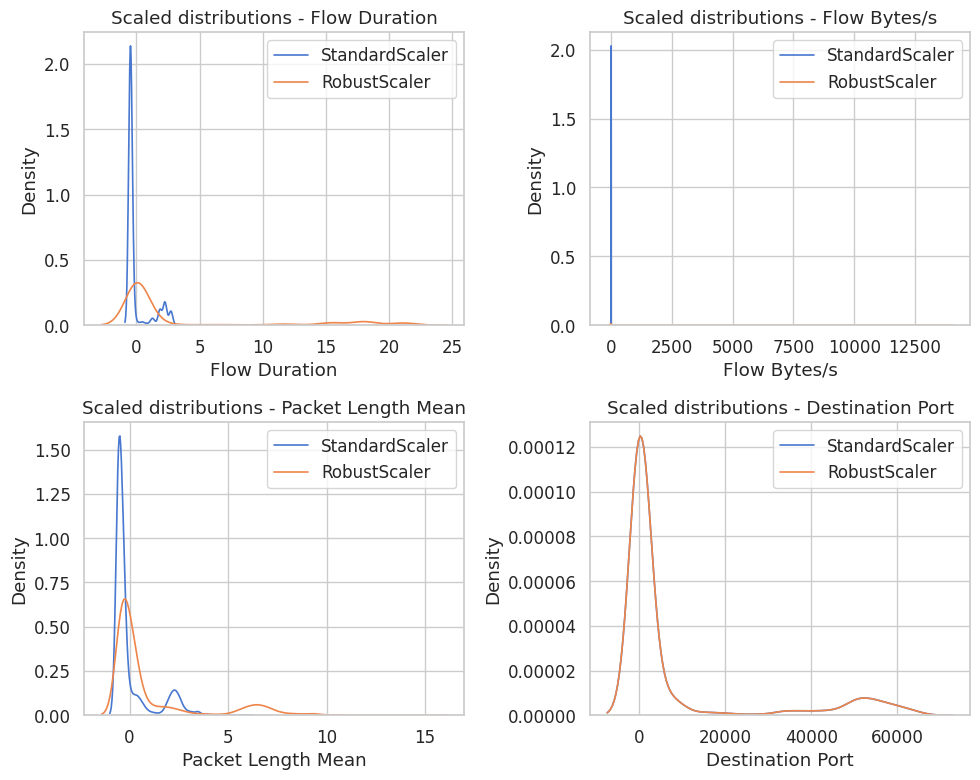

In [134]:
# ------------------------------------------------------------
# STEP 6 — Visual comparison of Standard vs Robust scaling
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i, col in enumerate(selected_features):
    sns.kdeplot(X_train_std[col], ax=axes[i//2, i%2], label="StandardScaler", lw=1.2)
    sns.kdeplot(X_train_rob[col], ax=axes[i//2, i%2], label="RobustScaler", lw=1.2)
    axes[i//2, i%2].set_title(f"Scaled distributions - {col}")
    axes[i//2, i%2].legend()
plt.tight_layout()
plt.show()

In [135]:
# ------------------------------------------------------------
# STEP 7 — Compare scaling statistics numerically
# ------------------------------------------------------------
stats_std = X_train_std_cont.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_std', 'std': 'std_std'})
stats_rob = X_train_rob_cont.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_rob', 'std': 'std_rob'})
scaling_comparison = stats_std.join(stats_rob)
print("\nScaling comparison (continuous features, first 10 rows):")
print(scaling_comparison.head(10))


Scaling comparison (continuous features, first 10 rows):
                            mean_std   std_std   mean_rob     std_rob
Flow Duration          -2.418046e-18  1.000028   3.209521    6.578692
Flow IAT Mean           3.627069e-17  1.000028   1.655390    4.604932
Bwd Packet Length Mean  8.261656e-17  1.000028   1.366380    3.176369
Bwd Packet Length Max   4.030076e-17  1.000028   2.137739    4.824989
Flow Bytes/s           -2.418046e-18  1.000028  10.549447  192.030725
Down/Up Ratio           7.898949e-17  1.000028  -0.333503    0.523037
Fwd Packet Length Mean  1.370226e-17  1.000028   0.251230    2.318150
Fwd IAT Std             9.107972e-17  1.000028   2.570055    6.266235
Packet Length Mean      6.951881e-17  1.000028   0.978281    2.402637
Fwd Packet Length Max   6.045114e-18  1.000028   0.593999    1.982455


In [136]:
# ------------------------------------------------------------
# STEP 8 — Save metadata for reproducibility
# ------------------------------------------------------------
metrics_dir = os.path.join(results_path, 'metrics')
os.makedirs(metrics_dir, exist_ok=True)

scalers_meta = {
    "StandardScaler": {
        "fit_on": "train",
        "num_features": len(cont_cols),
        "sensitivity": "mean/std (affected by outliers)"
    },
    "RobustScaler": {
        "fit_on": "train",
        "num_features": len(cont_cols),
        "sensitivity": "median/IQR (robust to outliers)"
    },
    "outlier_summary": {
        "top_zscore_features": outlier_counts_z.head(5).to_dict(),
        "top_iqr_features": outlier_counts_iqr.head(5).to_dict()
    }
}

with open(os.path.join(metrics_dir, "scalers_meta.json"), "w") as f:
    json.dump(scalers_meta, f, indent=2)

print("\nScaler metadata saved successfully.")
print(f"Standard-scaled shape: {X_train_std.shape}, Robust-scaled shape: {X_train_rob.shape}")


Scaler metadata saved successfully.
Standard-scaled shape: (17631, 16), Robust-scaled shape: (17631, 16)


## Task 2 — Shallow Neural Network (1 layer)
We will:
- Define a single-hidden-layer FFNN with hidden sizes h in {32, 64, 128}
- Use Linear activation as requested (i.e., no nonlinearity) for the first run
- Train with AdamW, lr=5e-4, batch=64, CE loss, up to 100 epochs with early stopping
- Plot train/val losses, select best by lowest val loss, report validation classification
- Evaluate best on test and compare to validation
- Then change activation to ReLU for the best width and retrain; discuss change

In [137]:
# -------------------------------------------------------------
# STEP 0 — Choose dataset version
# -------------------------------------------------------------
# Options: X_train_std, X_val_std, X_test_std
#          X_train_rob, X_val_rob, X_test_rob

X_train_use = X_train_rob   # change here if you want StandardScaler
X_val_use   = X_val_rob
X_test_use  = X_test_rob

y_train_use = y_train       # labels (assume already available)
y_val_use   = y_val
y_test_use  = y_test

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_use.values, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_use.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_use.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_use.values, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val_use.values, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test_use.values, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

In [138]:
# -------------------------------------------------------------
# STEP 1 — Define single-layer NN class
# -------------------------------------------------------------
class ShallowNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='linear'):
        super(ShallowNN, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.activation = activation
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if self.activation == 'relu':
            x = torch.relu(self.fc(x))
        elif self.activation == 'linear':
            x = self.fc(x)
        return self.out(x)

In [139]:
# -------------------------------------------------------------
# STEP 2 — Training function with early stopping
# -------------------------------------------------------------
def train_model(model, train_loader, val_loader, epochs=100, lr=0.0005, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_batch_losses.append(loss.item())
        val_loss = np.mean(val_batch_losses)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [140]:
# -------------------------------------------------------------
# STEP 3 — Train 3 models with different neurons (Linear activation)
# -------------------------------------------------------------
input_dim = X_train_use.shape[1]
output_dim = len(np.unique(y_train_use))
neurons_list = [32, 64, 128]

trained_models = {}
loss_curves = {}

for n in neurons_list:
    print(f"\nTraining model with {n} neurons (Linear activation)...")
    model = ShallowNN(input_dim, n, output_dim, activation='linear')
    model, train_loss, val_loss = train_model(model, train_loader, val_loader, epochs=100, lr=0.0005, patience=15)
    trained_models[n] = model
    loss_curves[n] = (train_loss, val_loss)


Training model with 32 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 14.4405, Val Loss: 1.8951
Epoch 10/100 - Train Loss: 2.9727, Val Loss: 3.5542
Epoch 20/100 - Train Loss: 2.4199, Val Loss: 0.7197
Epoch 30/100 - Train Loss: 2.6880, Val Loss: 1.3554
Early stopping at epoch 36

Training model with 64 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 10.0266, Val Loss: 5.4257
Epoch 10/100 - Train Loss: 5.0355, Val Loss: 4.7325
Epoch 20/100 - Train Loss: 3.5214, Val Loss: 3.8027
Early stopping at epoch 21

Training model with 128 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 21.1060, Val Loss: 21.0699
Epoch 10/100 - Train Loss: 8.9832, Val Loss: 1.2329
Epoch 20/100 - Train Loss: 6.8805, Val Loss: 12.4669
Early stopping at epoch 22


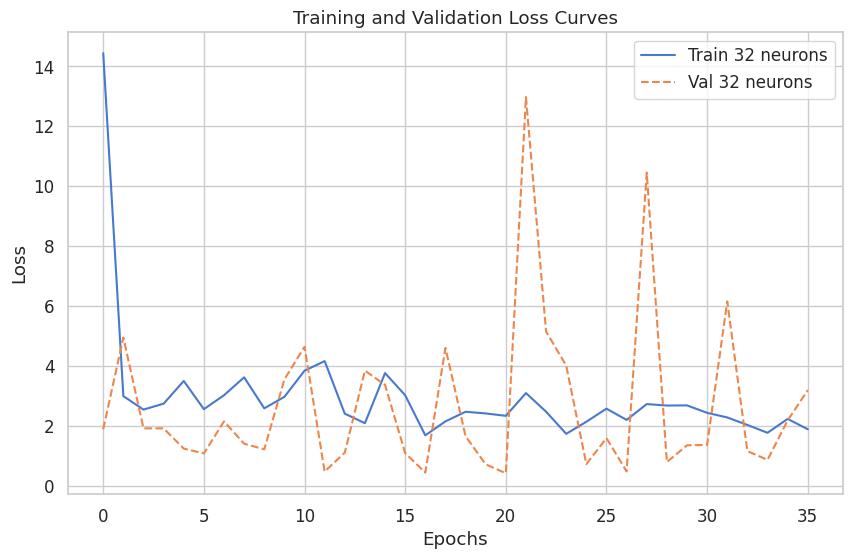

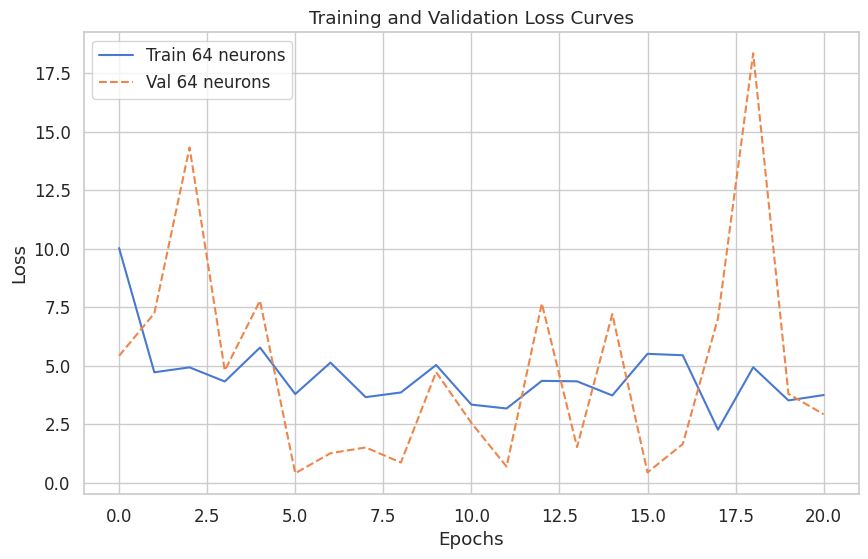

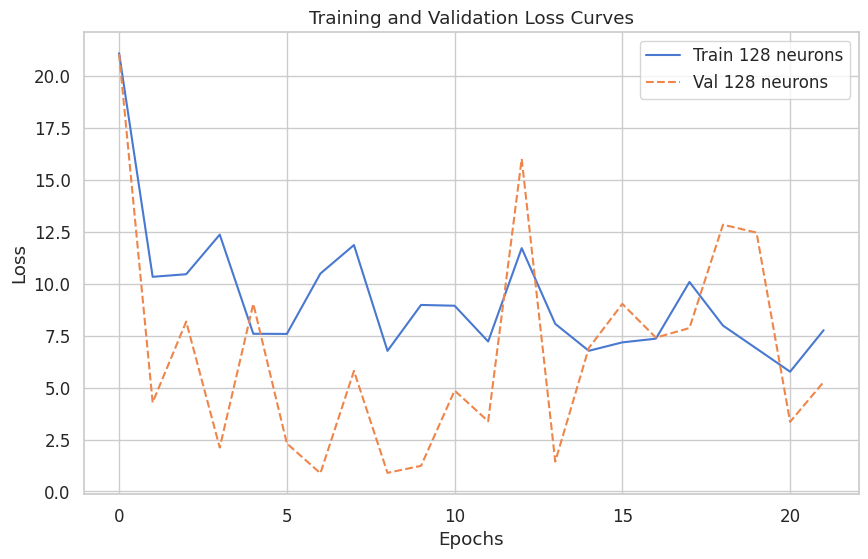

In [141]:
# -------------------------------------------------------------
# STEP 4 — Plot loss curves for all models
# -------------------------------------------------------------
for n in neurons_list:
    plt.figure(figsize=(10,6))
    train_loss, val_loss = loss_curves[n]
    plt.plot(train_loss, label=f'Train {n} neurons')
    plt.plot(val_loss, '--', label=f'Val {n} neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

In [142]:
# -------------------------------------------------------------
# STEP 5 — Evaluate validation set and print classification reports
# -------------------------------------------------------------
from sklearn.metrics import classification_report

def evaluate_model(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, axis=1).numpy()
    report = classification_report(y_true, y_pred, digits=4)
    return report

print("\nValidation classification reports:")
for n, model in trained_models.items():
    print(f"\n--- Model {n} neurons ---")
    report = evaluate_model(model, X_val_tensor, y_val_use)
    print(report)


Validation classification reports:

--- Model 32 neurons ---
              precision    recall  f1-score   support

           0     0.8393    0.9389    0.8863      3848
           1     0.6209    0.8706    0.7249       286
           2     0.9898    0.8758    0.9293       773
           3     0.7043    0.3536    0.4708       970

    accuracy                         0.8307      5877
   macro avg     0.7886    0.7597    0.7528      5877
weighted avg     0.8262    0.8307    0.8155      5877


--- Model 64 neurons ---
              precision    recall  f1-score   support

           0     0.8479    0.9374    0.8904      3848
           1     0.7302    0.8706    0.7943       286
           2     0.9812    0.8784    0.9270       773
           3     0.6881    0.4186    0.5205       970

    accuracy                         0.8407      5877
   macro avg     0.8119    0.7762    0.7830      5877
weighted avg     0.8333    0.8407    0.8295      5877


--- Model 128 neurons ---
              p

In [143]:
# -------------------------------------------------------------
# STEP 6 — Select best model and evaluate on test set
# -------------------------------------------------------------
# Example: pick model with 64 neurons (replace with your best)
best_n = 64
best_model = trained_models[best_n]

print("\nTest set classification report for best model:")
report_test = evaluate_model(best_model, X_test_tensor, y_test_use)
print(report_test)


Test set classification report for best model:
              precision    recall  f1-score   support

           0     0.8432    0.9428    0.8902      3849
           1     0.7385    0.8421    0.7869       285
           2     0.9823    0.8618    0.9181       774
           3     0.6737    0.3959    0.4987       970

    accuracy                         0.8370      5878
   macro avg     0.8094    0.7606    0.7735      5878
weighted avg     0.8284    0.8370    0.8243      5878




Retraining best model (64 neurons) with ReLU activation...
Epoch 1/100 - Train Loss: 15.4835, Val Loss: 3.2442
Epoch 10/100 - Train Loss: 2.1473, Val Loss: 2.8568
Epoch 20/100 - Train Loss: 2.7892, Val Loss: 6.6763
Early stopping at epoch 27


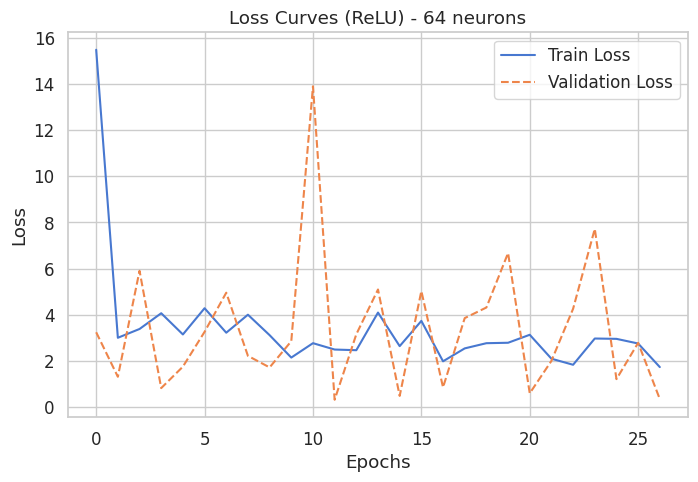


Validation classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9544    0.9356    0.9449      3848
           1     0.7435    0.9021    0.8152       286
           2     0.9689    0.9664    0.9676       773
           3     0.8480    0.8629    0.8554       970

    accuracy                         0.9260      5877
   macro avg     0.8787    0.9167    0.8958      5877
weighted avg     0.9285    0.9260    0.9268      5877



In [144]:
# -------------------------------------------------------------
# STEP 7 — Retrain best model with ReLU activation
# -------------------------------------------------------------
print(f"\nRetraining best model ({best_n} neurons) with ReLU activation...")
model_relu = ShallowNN(input_dim, best_n, output_dim, activation='relu')
model_relu, train_loss_relu, val_loss_relu = train_model(model_relu, train_loader, val_loader, epochs=100, lr=0.0005, patience=15)

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu, label='Train Loss')
plt.plot(val_loss_relu, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU) - {best_n} neurons')
plt.legend()
plt.show()

# Validation report for ReLU
print("\nValidation classification report (ReLU):")
report_val_relu = evaluate_model(model_relu, X_val_tensor, y_val_use)
print(report_val_relu)

## Task 3 — Impact of specific features (Destination Port)
Steps:
1) Modify only the test split: for rows with Label==Brute Force and Destination Port==80, change to 8080. Re-run inference with the best model and compare test metrics to validation baseline.
2) Remove the Destination Port feature entirely from the original dataset; redo preprocessing (cleaning, split, scaling); report PortScan counts before/after duplicates removal; discuss class balance.
Note: Keep a copy of the original splits to ensure fair comparisons.

In [ ]:
# 3.1: Modify Destination Port for Brute Force in Test and re-evaluate
if 'Destination Port' in feature_cols:
    # Build a modifiable DataFrame for test
    test_df = X_test.copy()
    test_df['Label'] = y_test.values
    before_counts = (test_df[(test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)].shape[0])
    # Change 80 -> 8080 for Brute Force
    mask = (test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)
    test_df.loc[mask, 'Destination Port'] = 8080
    after_counts = (test_df[(test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)].shape[0])
    print(f"Changed Brute Force port 80 -> 8080 in test: {before_counts} rows affected, now {after_counts} with port==80")

    # Re-standardize using the SAME scaler (train fit)
    test_df_std = scaler.transform(test_df[num_cols])
    X_test_mod_t = torch.tensor(test_df_std, dtype=torch.float32)
    y_test_mod_t = torch.tensor(y_test_i, dtype=torch.long)
    test_mod_loader = DataLoader(TensorDataset(X_test_mod_t, y_test_mod_t), batch_size=BATCH_SIZE)

    # Inference with the best validation model (from Task 2)
    mod_loss, mod_preds, mod_tgts = evaluate(best_model, test_mod_loader, nn.CrossEntropyLoss())
    print("Modified test loss:", round(mod_loss, 4))
    print(classification_report(mod_tgts, mod_preds, target_names=classes))
else:
    print("Destination Port feature not found; skip part 3.1.")

# 3.2: Remove Destination Port from the original dataset and redo preprocessing
if 'Destination Port' in feature_cols:
    noport_df = df.drop(columns=['Destination Port'])
    print("Shape without Destination Port:", noport_df.shape)
    # Remove duplicates specifically and count PortScan before/after
    portscan_before = df[df['Label']=='PortScan'].shape[0]
    noport_df_nodup = noport_df.drop_duplicates()
    labels_noport = noport_df_nodup['Label']
    portscan_after = noport_df_nodup[labels_noport=='PortScan'].shape[0]
    print(f"PortScan count before: {portscan_before}, after dropping duplicates (no port): {portscan_after}")
    print("Class balance (no port, after dedupe):\n", labels_noport.value_counts())
else:
    print("Destination Port feature not present; already removed earlier.")

## Task 4 — Impact of Loss Function (class weighting)
- Compute class weights from the training partition only, using sklearn `compute_class_weight(class_weight='balanced')`
- Retrain the best architecture (from Task 2 or after port removal, depending on stage)
- Compare per-class metrics, accuracy, and F1 against unweighted run

In [ ]:
# Compute class weights from TRAIN partition
classes_arr = np.array(classes)
weights = compute_class_weight(class_weight='balanced', classes=classes_arr, y=y_train.values)
print("Class weights (train):", dict(zip(classes, np.round(weights,3))))

# Map weights to class index order 0..NUM_CLASSES-1
weight_vec = np.array([weights[list(classes_arr).index(c)] for c in classes])

# Retrain best shallow width with weights (use ReLU variant for stronger baseline)
weighted_tag = f"shallow_weighted_h{best_h}"
weighted_model = ShallowFFNN(INPUT_DIM, best_h, NUM_CLASSES, activation='relu')
weighted_model, tr_w, va_w = train_model(
    weighted_model, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=weighted_tag,
    weight=weight_vec
)
va_loss_w, va_preds_w, va_tgts_w = evaluate(weighted_model, val_loader, nn.CrossEntropyLoss())
print("Validation (weighted):")
print(classification_report(va_tgts_w, va_preds_w, target_names=classes))

## Task 5 — Deep Neural Networks, Batch Size, Optimizers
We will:
- Try depths L in {3, 4, 5} and for each try 2 hidden-size patterns (total 6)
- Use ReLU, AdamW, lr=5e-4, epochs<=50 with early stopping
- Select best by validation; evaluate best on test
- Compare batch sizes {4, 64, 256, 1024} on best arch: report validation metrics and wall-clock time
- Compare optimizers: SGD, SGD+Momentum (0.1, 0.5, 0.9), AdamW; analyze losses and times; then tune LR/epochs for the best

In [ ]:
class DeepFFNN(nn.Module):
    def __init__(self, input_dim, layers, num_classes):
        super().__init__()
        dims = [input_dim] + layers
        mods = []
        for i in range(len(dims)-1):
            mods.append(nn.Linear(dims[i], dims[i+1]))
            mods.append(nn.ReLU())
        mods.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*mods)
    def forward(self, x):
        return self.net(x)

# Architectures to try: two per depth 3,4,5
arch_grid = {
    3: [[32,16,8],[64,32,16]],
    4: [[64,32,16,8],[32,32,16,8]],
    5: [[128,64,32,16,8],[32,32,32,16,8]],
}

arch_results = []
for depth, patterns in arch_grid.items():
    for pattern in patterns:
        tag = f"deep_L{depth}_h{'-'.join(map(str,pattern))}"
        model = DeepFFNN(INPUT_DIM, pattern, NUM_CLASSES)
        model, tr_d, va_d = train_model(model, train_loader, val_loader, epochs=50, lr=5e-4, patience=8, tag=tag)
        va_loss_d, va_preds_d, va_tgts_d = evaluate(model, val_loader, nn.CrossEntropyLoss())
        rep_d = classification_report(va_tgts_d, va_preds_d, target_names=classes, output_dict=True)
        arch_results.append({"depth":depth, "pattern":pattern, "val_loss":va_loss_d, "report":rep_d, "model":model, "tag":tag})

best_deep = min(arch_results, key=lambda r: r['val_loss'])
print("Best deep arch:", best_deep['pattern'], "(L=", len(best_deep['pattern']), ") val_loss=", round(best_deep['val_loss'],4))

# Evaluate best deep on test
best_deep_model = best_deep['model']
loss_td, preds_td, tgts_td = evaluate(best_deep_model, test_loader, nn.CrossEntropyLoss())
print("Test report (best deep):")
print(classification_report(tgts_td, preds_td, target_names=classes))

# Batch size experiment
for bs in [4, 64, 256, 1024]:
    tl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    vl = DataLoader(val_ds, batch_size=bs)
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES)
    start = time.time()
    model, tr_b, va_b = train_model(model, tl, vl, epochs=50, lr=5e-4, patience=8, tag=f"deep_bs{bs}")
    elapsed = time.time()-start
    va_loss_b, va_preds_b, va_tgts_b = evaluate(model, vl, nn.CrossEntropyLoss())
    print(f"BS={bs}: val_loss={va_loss_b:.4f}, time={elapsed:.1f}s")

# Optimizer experiment
optims = [
    ("SGD", lambda params: optim.SGD(params, lr=5e-3)),
    ("SGD_m0.1", lambda params: optim.SGD(params, lr=5e-3, momentum=0.1)),
    ("SGD_m0.5", lambda params: optim.SGD(params, lr=5e-3, momentum=0.5)),
    ("SGD_m0.9", lambda params: optim.SGD(params, lr=5e-3, momentum=0.9)),
    ("AdamW", lambda params: optim.AdamW(params, lr=5e-4)),
]

opt_results = []
for name, factory in optims:
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = factory(model.parameters())
    es = EarlyStopper(patience=8, mode='min')
    tr_losses, va_losses = [], []
    start = time.time()
    for ep in range(50):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr); va_losses.append(va)
        if es.step(va):
            break
    elapsed = time.time()-start
    va_loss_o, va_preds_o, va_tgts_o = evaluate(model, val_loader, criterion)
    opt_results.append((name, va_loss_o, elapsed))
    # Use the global FIG_DIR for saving optimizer plots
    plot_losses(tr_losses, va_losses, f"opt_{name}", save_path=FIG_DIR/f"opt_{name}_loss.png")

print("Optimizer comparison (name, val_loss, time_s):", [(n, round(l,4), round(t,1)) for n,l,t in opt_results])

## Task 6 — Overfitting and Regularization
- Build 6-layer FFNN with widths [256, 128, 64, 32, 16] (the final layer is num_classes)
- Train with ReLU, AdamW lr=5e-4, batch=128, epochs=50
- Inspect losses for signs of overfitting
- Add Dropout and BatchNorm variants; try weight decay (AdamW) and compare validation/test

In [ ]:
class RegFFNN(nn.Module):
    def __init__(self, input_dim, widths, num_classes, dropout=0.0, batchnorm=False):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers.append(nn.Linear(prev, w))
            if batchnorm:
                layers.append(nn.BatchNorm1d(w))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = w
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Baseline (no regularization)
widths6 = [256,128,64,32,16]
BATCH_SIZE = 128
train_loader6 = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader6   = DataLoader(val_ds, batch_size=BATCH_SIZE)

model6 = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=0.0, batchnorm=False)
model6, tr6, va6 = train_model(model6, train_loader6, val_loader6, epochs=50, lr=5e-4, patience=8, tag="reg_L6_base")
va_loss6, va_preds6, va_tgts6 = evaluate(model6, val_loader6, nn.CrossEntropyLoss())
print("Validation (no regularization):")
print(classification_report(va_tgts6, va_preds6, target_names=classes))

# Dropout + BatchNorm + weight decay variants
for dp in [0.2, 0.5]:
    for bn in [False, True]:
        tag = f"reg_L6_dp{dp}_bn{int(bn)}"
        m = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=dp, batchnorm=bn).to(device)
        weight_decay = 1e-4 if bn else 5e-4
        # Custom train loop to set weight decay
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(m.parameters(), lr=5e-4, weight_decay=weight_decay)
        es = EarlyStopper(patience=8, mode='min')
        tr_losses, va_losses = [], []
        for ep in range(50):
            tr = train_one_epoch(m, train_loader6, criterion, optimizer)
            va, _, _ = evaluate(m, val_loader6, criterion)
            tr_losses.append(tr); va_losses.append(va)
            if es.step(va):
                break
        # Use the global FIG_DIR for saving regularization plots
        plot_losses(tr_losses, va_losses, tag, save_path=FIG_DIR/f"{tag}_loss.png")
        vLoss, vp, vt = evaluate(m, val_loader6, criterion)
        print(f"Variant {tag} — val_loss={vLoss:.4f}")

In [ ]:
class ShallowFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, activation='linear'):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.activation = activation
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc_out(x)


def train_model(model, train_loader, val_loader, epochs=100, lr=5e-4, weight=None, patience=10, tag="model"):
    model = model.to(device)
    weight_t = torch.tensor(weight, dtype=torch.float32, device=device) if weight is not None else None
    criterion = nn.CrossEntropyLoss(weight=weight_t)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    es = EarlyStopper(patience=patience, mode='min')

    tr_losses, va_losses = [] , []
    best_state, best_va = None, float('inf')

    # Assuming FIG_DIR is defined elsewhere, create it if not
    global FIG_DIR # Access the global variable
    if 'FIG_DIR' not in globals():
         FIG_DIR = Path(results_path) / 'figures' # Or wherever you want to save
         os.makedirs(FIG_DIR, exist_ok=True)


    for ep in range(epochs):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr)
        va_losses.append(va)
        if va < best_va:
            best_va = va
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        if es.step(va):
            break
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    # plot
    plot_losses(tr_losses, va_losses, f"{tag} losses", save_path=FIG_DIR/f"{tag}_loss.png")
    return model, tr_losses, va_losses

# Train three widths with linear activation
hidden_sizes = [32, 64, 128]
results = []
for h in hidden_sizes:
    tag = f"shallow_linear_h{h}"
    m = ShallowFFNN(INPUT_DIM, h, NUM_CLASSES, activation='linear')
    m, tr, va = train_model(m, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=tag)
    va_loss, va_preds, va_tgts = evaluate(m, val_loader, nn.CrossEntropyLoss())
    rep = classification_report(va_tgts, va_preds, target_names=classes, output_dict=True)
    results.append({"h":h, "val_loss":va_loss, "report":rep, "model":m})
    # save report
    with open(METRICS_DIR/f"{tag}_val_report.json", "w") as f:
        json.dump(rep, f, indent=2)

# Select best by lowest val loss
best = min(results, key=lambda r: r["val_loss"])
print("Best width (linear):", best["h"], "val_loss:", best["val_loss"])

In [ ]:
# Validation reports for the 3 linear models (summary)
for r in results:
    h = r['h']
    rep = r['report']
    print(f"\nWidth {h} — Val loss: {r['val_loss']:.4f}")
    # Compact summary per class + macro/weighted
    keys = list(classes) + ['macro avg','weighted avg','accuracy']
    compact = {}
    for k in keys:
        if k in rep:
            if k == 'accuracy':
                compact[k] = round(rep[k], 4)
            else:
                compact[k] = {m: round(rep[k][m], 4) for m in ['precision','recall','f1-score'] if m in rep[k]}
    print(compact)

# Test evaluation for best linear model
best_model = best['model']
test_loss, test_preds, test_tgts = evaluate(best_model, test_loader, nn.CrossEntropyLoss())
print("\nTest loss (best linear):", round(test_loss, 4))
print("Validation vs Test — compare metrics (test shown below)")
print(classification_report(test_tgts, test_preds, target_names=classes))